# Numerical optimization

You will learn to solve non-convex multi-dimensional optimization problems using numerical optimization with multistart and nesting (**scipy.optimize**). You will learn simple function approximation using linear interpolation (**scipy.interp**). 

**Links:**

1. **scipy.optimize:** [overview](https://docs.scipy.org/doc/scipy/reference/optimize.html) + [tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)
2. **scipy.interp:** [overview](https://docs.scipy.org/doc/scipy/reference/interpolate.html) + [tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html)

**Useful note:** [Numerical Optimization in MATLAB](http://web.econ.ku.dk/munk-nielsen/notes/noteOptimization.pdf) (by Anders Munk-Nielsen)

[<img src="https://mybinder.org/badge_logo.svg">](https://mybinder.org/v2/gh/NumEconCopenhagen/lectures-2019/master?urlpath=lab/tree/10/Numerical_optimization.ipynb)

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Introduction

All **optimization problems** are characterized by:

1. Control vector (choices), $\boldsymbol{x} \in \mathbb{R}^k$
2. Objective function (payoff) to minimize, $f:\mathbb{R}^k \rightarrow \mathbb{R}$ (differentiable or not)
3. Constraints, i.e. $\boldsymbol{x}  \in C \subseteq \mathbb{R}^k$ (linear or non-linear interdependence)

**Maximization** is just **minimization** of $-f$. 

> Note that $f$ might also take other inputs (parameters or a dataset), but these are fixed, and therefore not variables we optimize over.

All **optimizers** (minimizers) follow the structure:

1. Make initial guess
2. Evaluate the function (and perhaps gradients)
3. Check for convergence
4. Update guess and return to step 2

**Convergence:** "Small" change in function value since last iteration (or zero gradient).

**Characteristics** of optimizers:

1. Use gradients or not.
2. Allow for specifying bounds.
3. Allow for specifying general constraints.

**Gradients** provide useful information, but can be costly to compute (using analytical formula or numerically).

**Penalty terms** can (sometimes) instead be used to enforce bounds and constraints.

**Optimizers** you should know:

1. **Nelder-Mead:** 
 * **Pro:** Robust (to e.g. noise in objective function) and does not require derivatives.
 * **Con:** Slow convergence. No bounds or constraints.
* **Newton-CG:**
 * **Pro:** Require few iterations. Very precise with analytical hessian for smooth functions.
 * **Con:** Costly computation of hessian. No bounds or constraints.
* **BFGS:** (like newton, but with smart computation of hessian)
  * **Pro:** Require few function evaluations. 
  * **Con:** No bounds or constraints.
* **L-BFGS-B:** Like BFGS, but allows for bounds.
* **SLSQP:**
  * **Pro:** Bounds and constraints in multiple dimensions.
  * **Con:** Not as efficient as BFGS.

## Gradient based optimizers

Let us look at the idea behind gradient based optimizers.

**One dimensional intuition:** Consider the second-order Taylor approximation around $x_n$:

$$ f_T(x) = f_T(x_n + \Delta x) \approx f(x_n)+ f^{\prime}(x_n) \Delta x + \frac{1}{2} f^{\prime\prime}(x_n) (\Delta x)^2 $$

Find the minimum wrt. to $\Delta x$ by solving the FOC:

$$ 0 = \frac{d}{d\Delta x} f_T(x) = f^{\prime}(x_n) + f^{\prime\prime}(x_n) \Delta x \Leftrightarrow \Delta x = -\frac{f^{\prime}(x_n)}{f^{\prime\prime}(x_n)}$$


**Algorithm:** `minimize_newton()`

1. Choose tolerance $\epsilon>0$, guess on $\boldsymbol{x}_0$, compute $f(\boldsymbol{x}_0)$, and set $n=1$.
2. Compute $\nabla f(\boldsymbol{x}_{n-1})$ (gradient/jacobian) and $\boldsymbol{H}f(\boldsymbol{x}_{n-1})$ (hessian).
3. Compute new guess

  $$ \boldsymbol{x}_{n} = \boldsymbol{x}_{n-1} - [\boldsymbol{H}f(\boldsymbol{x}_{n-1})]^{-1} \nabla f(\boldsymbol{x}_{n-1}) $$

3. If $|f(\boldsymbol{x}_n)-f(\boldsymbol{x}_{n-1})| < \epsilon$ then stop.
5. Set $n = n + 1$ and return to step 2.

In [2]:
def minimize_newton(f,x0,jac,hess,max_iter=500,tol=1e-8):
    """ minimize function with Newtons' algorithm
        
    Args:

        f (callable): function
        x0 (float): initial value
        jac (callable): jacobian
        hess (callable): hessian
        max_iter (int): maximum number of iterations
        tol (float): tolerance
        
    Returns:
    
        x (float): root
        n (int): number of iterations used
        
    """
    
    # step 1: initialize
    x = x0
    fx = f(x0)
    n = 1
    
    # step 2-5: iteration
    while n < max_iter:
        
        x_prev = x
        fx_prev = fx
        
        # step 2: evaluate gradient and hessian
        jacx = jac(x_prev)
        hessx = hess(x_prev)
        
        # step 3: update x
        inv_hessx = linalg.inv(hessx)        
        x = x_prev - inv_hessx@jacx
     
        # step 4: check convergence
        fx = f(x)
        if abs(fx-fx_prev) < tol:
            break
            
        # step 5: increment n
        n += 1
        
    return x,n

**Algorithm:** `minimize_gradient_descent()`

1. Choose tolerance $\epsilon>0$, potential step sizes, $ \boldsymbol{\alpha} = [\alpha_0,\alpha_1,\dots,\alpha_\#]$, guess on $\boldsymbol{x}_0$, compute $f(\boldsymbol{x}_0)$, and set $n=1$.
2. Compute $\nabla f(\boldsymbol{x}_{n-1})$.
3. Find good step size:

  $$ \alpha^{\ast} = \arg \min_{\alpha \in \boldsymbol{\alpha}}  f(\boldsymbol{x}_{n-1} - \alpha \nabla f(\boldsymbol{x}_{n-1})) $$

4. Compute new guess:

  $$\boldsymbol{x}_{n} = \boldsymbol{x}_{n-1} - \alpha^{\ast} \nabla f(\boldsymbol{x}_{n-1}) $$

5. If $|f(\boldsymbol{x}_n)-f(\boldsymbol{x}_{n-1})| < \epsilon\\) then stop.
6. Set $n = n + 1$ and return to step 2.

In [3]:
def minimize_gradient_descent(f,x0,jac,alphas=[0.01,0.05,0.1,0.25,0.5,1],max_iter=500,tol=1e-8):
    """ minimize function with gradient descent
        
    Args:

        f (callable): function
        x0 (float): initial value
        jac (callable): jacobian
        alpha (list): potential step sizes
        max_iter (int): maximum number of iterations
        tol (float): tolerance
        
    Returns:
    
        x (float): root
        n (int): number of iterations used
        
    """
    
    # step 1: initialize
    x = x0
    fx = f(x0)
    n = 1
    
    # step 2-6: iteration
    while n < max_iter:
            
        x_prev = x
        fx_prev = fx
        
        # step 2: evaluate gradient
        jacx = jac(x)
        
        # step 3: find good step size 
        fx_ast = np.inf
        alpha_ast = np.nan
        for alpha in alphas:
            x = x_prev - alpha*jacx
            fx = f(x)
            if fx < fx_ast:
                fx_ast = fx
                alpha_ast = alpha
        
        # step 4: update guess
        x = x_prev - alpha_ast*jacx
                            
        # step 5: check convergence
        fx = f(x)
        if abs(fx-fx_prev) < tol:
            break
            
        # d. update i
        n += 1
        
    return x,n

**Many generalizations:**

1. Use both Hessian and line search
2. Stop line search when improvement found
3. Limit attention to a "trust-region"

etc. etc. etc. etc.

# Example: The rosenbrock function

Consider the **rosenbrock function**:

$$ f(\boldsymbol{x}) = f(x_1,x_2) =0.5(1-x_{1})^{2}+(x_{2}-x_{1}^{2})^{2} $$

with **jacobian** (gradient)

$$ \nabla f(\boldsymbol{x})=\begin{bmatrix}\frac{\partial f}{\partial x_{1}}\\
\frac{\partial f}{\partial x_{2}}
\end{bmatrix}=\begin{bmatrix}-(1-x_{1})-4x_{1}(x_{2}-x_{1}^{2})\\
2(x_{2}-x_{1}^{2})
\end{bmatrix} $$

and **hessian**:

$$ \boldsymbol{H}f(\boldsymbol{x})=\begin{bmatrix}\frac{\partial f}{\partial x_{1}x_{1}} & \frac{\partial f}{\partial x_{1}x_{2}}\\
\frac{\partial f}{\partial x_{1}x_{2}} & \frac{\partial f}{\partial x_{2}x_{2}}
\end{bmatrix}=\begin{bmatrix}1-4x_{2}+12x_{1}^{2} & -4x_{1}\\
-4x_{1} & 2
\end{bmatrix} $$

**Note:** Minimum is at $(1,1)$ where $f(1,1)=0$.

**Check jacobian and hessian:**

In [4]:
sm.init_printing(use_unicode=True)
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = 0.5*(1.0-x1)**2 + (x2-x1**2)**2

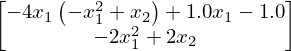

In [5]:
Df = sm.Matrix([sm.diff(f,i) for i in [x1,x2]])
Df

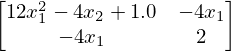

In [6]:
Hf = sm.Matrix([[sm.diff(f,i,j) for j in [x1,x2]] for i in [x1,x2]])
Hf

**Implementation:**

In [7]:
def _rosen(x1,x2):
    return 0.5*(1.0-x1)**2+(x2-x1**2)**2
def rosen(x):
    return _rosen(x[0],x[1])
def rosen_jac(x):
    return np.array([-(1.0-x[0])-4*x[0]*(x[1]-x[0]**2),2*(x[1]-x[0]**2)])
def rosen_hess(x):
    return np.array([[1-4*x[1]+12*x[0]**2,-4*x[0]],[-4*x[0],2]])

**3D Plot:**

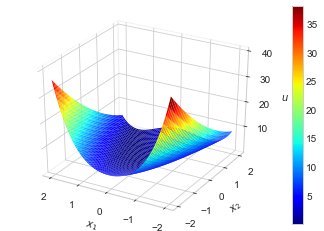

In [8]:
# a. grids
x1_vec = np.linspace(-2,2,500)
x2_vec = np.linspace(-2,2,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
rosen_grid = _rosen(x1_grid,x2_grid)

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,rosen_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$u$')

# d. invert xaxis
ax.invert_xaxis()

# e. remove background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# f. add colorbar
fig.colorbar(cs);

**Contour plot:**

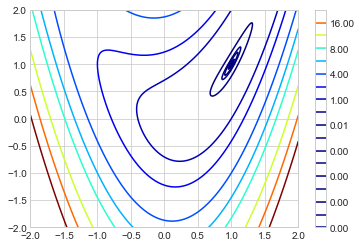

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
levels = [1e-6,5*1e-6,1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2,1,2,4,6,8,12,16,20]
cs = ax.contour(x1_grid,x2_grid,rosen_grid,levels=levels,cmap=cm.jet)
fig.colorbar(cs);

**Newton:**

In [10]:
x0 = np.array([5,4])
x,n = minimize_newton(rosen,x0,rosen_jac,rosen_hess)
print(n,x,rosen(x))

6 [1. 1.] 0.0


**Gradient descent:**

In [11]:
x0 = np.array([5,4])
x,n = minimize_gradient_descent(rosen,x0,rosen_jac,alphas=[0.01,0.05,0.1,0.25,0.5,1])
print(n,x,rosen(x))

173 [1.00020519 1.00053964] 3.7750814497569406e-08


## Scipy minimizers

**Preperation I:** Function for collecting infomation while running optimizing:

In [12]:
# complicated -> not necessary to understand it
def collect(x):
    
    # globals used to keep track across iterations
    global evals # set evals = 0 before calling optimizer
    global x0
    global x1s
    global x2s
    global fs
    
    # a. initialize list
    if evals == 0:
        x1s = [x0[0]] 
        x2s = [x0[1]]
        fs = [rosen(x0)]
        
    # b. append trial values
    x1s.append(x[0])
    x2s.append(x[1])
    fs.append(rosen(x))
    
    # c. increment number of evaluations
    evals += 1

**Preperation II:** Function plotting the collected information:

In [13]:
# complicated -> not necessary to understand it
def contour():
    
    global evals
    global x1s
    global x2s
    global fs
    
    # a. contour plot
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    levels = [1e-6,5*1e-6,1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2,1,2,4,6,8,12,16,20]
    cs = ax.contour(x1_grid,x2_grid,rosen_grid,levels=levels,cmap=cm.jet)
    fig.colorbar(cs)
    ax.plot(x1s,x2s,'-o',ms=4,color='black')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    # b. function value
    ax = fig.add_subplot(1,2,2)
    ax.plot(np.arange(evals+1),fs,'-o',ms=4,color='black')
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

**Nelder-Mead**

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 57
         Function evaluations: 105


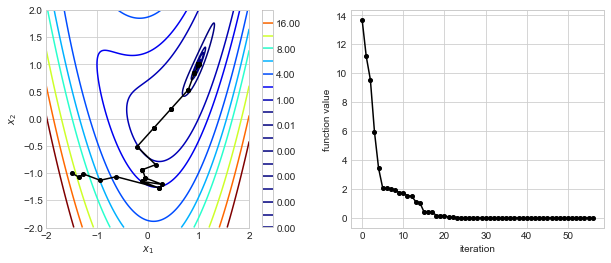

In [14]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='Nelder-Mead',
                           callback=collect, # call the collect() before each iteration
                           options={'disp':True}) # display the results
contour()

> **Note:** Does not require a gradient. Slow convergence close to target.

**Newton** (with analytical hessian)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 22
         Hessian evaluations: 11


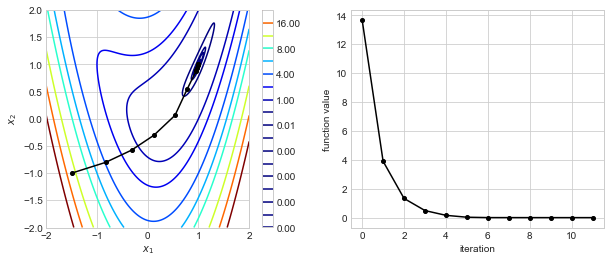

In [15]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,hess=rosen_hess,
                           method='Newton-CG',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Smoother and faster.

**Newton** (with numerical hessian computed scipy)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 58
         Hessian evaluations: 0


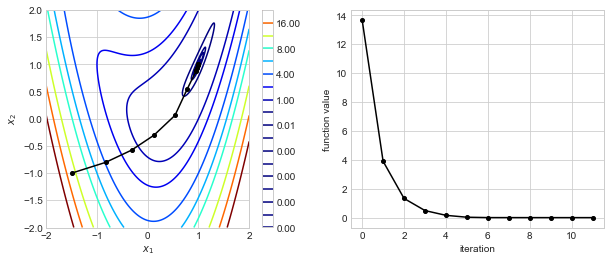

In [16]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='Newton-CG',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Same as above, but gradient evaluations instead of hessian evaluations.

**BFGS** (with analytical gradient)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14


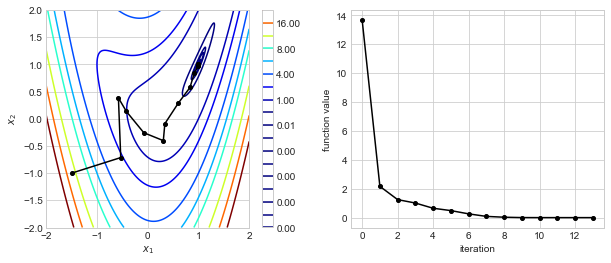

In [17]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Non-smooth, but fast. Very low number of function evaluations.

**BFGS** (with numerical gradient computed by scipy)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 56
         Gradient evaluations: 14


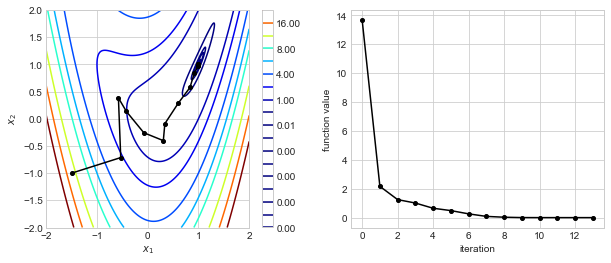

In [18]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Same as above, but more function evaluations.

**L-BFGS-B** (with analytical gradient)

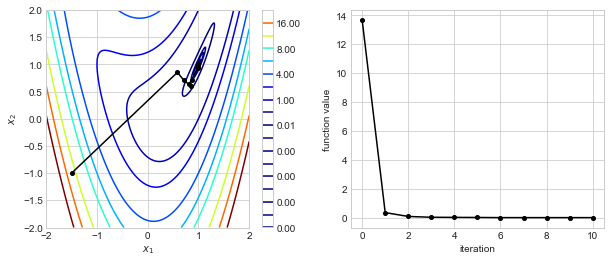

In [19]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='L-BFGS-B',
                           bounds=((-3,3),(-3,3)),
                           callback=collect,
                           options={'disp':True})
contour()

**SLSQP**

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.7296908855910356e-09
            Iterations: 10
            Function evaluations: 13
            Gradient evaluations: 10


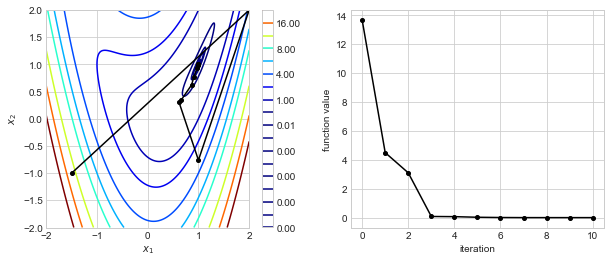

In [20]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='SLSQP',
                           bounds=((-2,2),(-2,2)),
                           callback=collect,
                           options={'disp':True})
contour()

## Controling the optimizers

> **Note:** See the settings for each optimizer in the [documention](https://docs.scipy.org/doc/scipy/reference/optimize.html).

We can lower the **tolerance**:

In [21]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True,'gtol':1e-2}) # note this
# contour()

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 11
         Function evaluations: 48
         Gradient evaluations: 12


We can change the **maximum number of iterations**:

         Current function value: 0.486266
         Iterations: 5
         Function evaluations: 24
         Gradient evaluations: 6


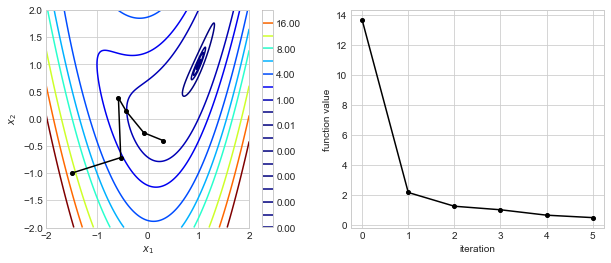

In [22]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True,'maxiter':5}) # note this and warning
contour()

## Sombrero function: Local minima and multistart

Consider the **sombrero** function

$$f(x_1,x_2) = g\Big(\sqrt{x_1^2 + x_2^2}\Big) $$

where

$$g(r) = -\frac{\sin(r)}{r+10^{-4}} + 10^{-4}r^2 $$

The **global minimum** of this function is (0,0). But the function also have (infinitely many) **local minima**. How to avoid these?

In [23]:
def _sombrero(x1,x2):
    r = np.sqrt(x1**2 + x2**2)
    return -np.sin(r)/(r+1e-4) + 1e-4*r**2
    
sombrero = lambda x: _sombrero(x[0],x[1])

## 3D plot

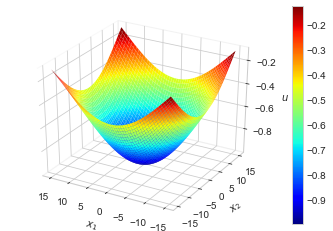

In [24]:
# a. grids
x1_vec = np.linspace(-15,15,500)
x2_vec = np.linspace(-15,15,500)
x1_grid_sombrero,x2_grid_sombrero = np.meshgrid(x1_vec,x2_vec,indexing='ij')
sombrero_grid = _sombrero(x1_grid,x2_grid)

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid_sombrero,x2_grid_sombrero,sombrero_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$u$')

# d. invert xaxis
ax.invert_xaxis()

# e. remove background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# f. colorbar
fig.colorbar(cs);

## Multistart - BFGS

**Multi-start:** Draw many random starting values:

In [25]:
np.random.seed(1986)
x0s = -15 + 30*np.random.uniform(size=(5000,2)) # in [-15,15]
xs = np.empty((5000,2))
fs = np.empty(5000)

Try to solve with **BFGS** starting from each of these:

In [26]:
fopt = np.inf
xopt = np.nan
for i,x0 in enumerate(x0s):
    
    # a. optimize
    result = optimize.minimize(sombrero,x0,method='BFGS')
    xs[i,:] = result.x
    f = result.fun
    
    # b. print first 10 or if better than seen yet
    if i < 10 or f < fopt: # plot 10 first or if improving
        if f < fopt:
            fopt = f
            xopt = xs[i,:]
            
        print(f'{i:4d}: x0 = ({x0[0]:6.2f},{x0[0]:6.2f})',end='')
        print(f' -> converged at ({xs[i][0]:6.2f},{xs[i][0]:6.2f}) with f = {f:.12f}')
        
# best solution
print(f'\nbest solution:\n x = ({xopt[0]:6.2f},{xopt[1]:6.2f}) -> f = {fopt:.12f}')

   0: x0 = (  2.07,  2.07) -> converged at (  2.26,  2.26) with f = -0.051182722123
   1: x0 = (  3.25,  3.25) -> converged at (  3.69,  3.69) with f = -0.051182722111
   2: x0 = (  1.35,  1.35) -> converged at (  1.67,  1.67) with f = -0.122414211497
   3: x0 = ( -3.42, -3.42) -> converged at ( -4.63, -4.63) with f = -0.122414211494
   4: x0 = (  5.70,  5.70) -> converged at (  5.06,  5.06) with f = -0.122414211497
   5: x0 = (  5.71,  5.71) -> converged at (  4.06,  4.06) with f = -0.122414211468
   6: x0 = ( -6.49, -6.49) -> converged at ( -4.96, -4.96) with f = -0.122414211497
   7: x0 = ( -5.77, -5.77) -> converged at ( -7.34, -7.34) with f = -0.122414211356
   8: x0 = (  1.58,  1.58) -> converged at (  0.04,  0.04) with f = -0.997762360170
   9: x0 = (  2.33,  2.33) -> converged at (  2.72,  2.72) with f = -0.051182722123
  25: x0 = (  1.41,  1.41) -> converged at (  0.03,  0.03) with f = -0.997762360171
 150: x0 = (-14.53,-14.53) -> converged at ( -0.06, -0.06) with f = -0.99776

The solver, wrongly, **converges to many of the local minima**:

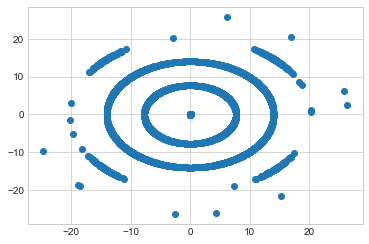

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1]);

## Multistart - Nelder-Mead

Try to solve with **Nelder-Mead** starting from each of these:

In [28]:
fopt = np.inf
xopt = np.nan
for i,x0 in enumerate(x0s):
    
    # a. optimize
    result = optimize.minimize(sombrero,x0,method='Nelder-Mead')
    xs[i,:] = result.x
    f = result.fun
    
    # b. print first 10 or if better than seen yet
    if i < 10 or f < fopt: # plot 10 first or if improving
        if f < fopt:
            fopt = f
            xopt = xs[i,:]
        print(f'{i:4d}: x0 = ({x0[0]:6.2f},{x0[0]:6.2f})',end='')
        print(f' -> converged at ({xs[i][0]:6.2f},{xs[i][1]:6.2f}) with f = {f:.12f}')

# best solution
print(f'\nbest solution:\n x = ({xopt[0]:6.2f},{xopt[1]:6.2f}) -> f = {fopt:.12f}')

   0: x0 = (  2.07,  2.07) -> converged at (  2.20,-13.85) with f = -0.051182722123
   1: x0 = (  3.25,  3.25) -> converged at (  3.43, 13.60) with f = -0.051182722123
   2: x0 = (  1.35,  1.35) -> converged at (  1.39,  7.59) with f = -0.122414211497
   3: x0 = ( -3.42, -3.42) -> converged at ( -3.71,  6.76) with f = -0.122414211497
   4: x0 = (  5.70,  5.70) -> converged at (  6.69,  3.84) with f = -0.122414211497
   5: x0 = (  5.71,  5.71) -> converged at (  4.98, 13.11) with f = -0.051182722123
   6: x0 = ( -6.49, -6.49) -> converged at ( -7.34,  2.37) with f = -0.122414211497
   7: x0 = ( -5.77, -5.77) -> converged at ( -7.45, -2.01) with f = -0.122414211497
   8: x0 = (  1.58,  1.58) -> converged at ( -0.02,  0.06) with f = -0.997762360171
   9: x0 = (  2.33,  2.33) -> converged at (  2.36, 13.83) with f = -0.051182722123

best solution:
 x = ( -0.02,  0.06) -> f = -0.997762360171


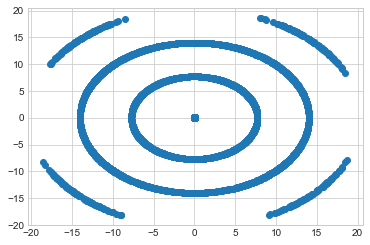

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1]);

# Constraints

Consider the **constrained problem**:

$$\min_{x_1,x_2,x_3,x_4} x_1x_4(x_1+x_2+x_3) + x_3$$

subject to

$$x_1x_2x_3x_4 \geq 25$$
$$x_1^2x_2^2x_3^2x_4^2 = 40$$
$$1 \leq x_1,x_2,x_3,x_4 \leq 5$$

Define **objective** and **constraints**:

In [30]:
def _objective(x1,x2,x3,x4):
    return x1*x4*(x1+x2+x3)+x3

def objective(x):
    return _objective(x[0],x[1],x[2],x[3])

def ineq_constraint(x):
    return x[0]*x[1]*x[2]*x[3]-25.0

def eq_constraint(x):
    sum_eq = 40.0
    for i in range(4):
        sum_eq = sum_eq - x[i]**2
    return sum_eq

In [31]:
# a. setup
bound = (1.0,5.0)
bounds = (bound, bound, bound, bound)
ineq_con = {'type': 'ineq', 'fun': ineq_constraint} 
eq_con = {'type': 'eq', 'fun': eq_constraint}

# b. call optimizer
x0 = (40**(1/8),40**(1/8),40**(1/8),40**(1/8)) # fit the equality constraint
result = optimize.minimize(objective,x0,
                             method='SLSQP',
                             bounds=bounds,
                             constraints=[ineq_con,eq_con],
                             options={'disp':True})

print('\nx = ',result.x)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 17.01401728904412
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9

x =  [1.         4.74299967 3.82114994 1.3794083 ]


**Altenrative:** Extend the **objective function with a penalty term**, where guesses outside the allowed bounds and constraints are projected into the allowed region, but a (large) penalty term is added to discourage this. Solve this problem with an unconstrained solver. Not always easy to do in practice if there are multiple constraint (see lecture 3 for a simple example).

# Interpolation

**Intermezzo:** To consider dynamic optimization problems, we need to think about interpolation.

**Inputs:**

1. Sorted vector of known points (grid vector), $G$
2. Vector of known values (at these points), $F$
3. A new point, `x`

**Algorithm:** `linear_interpolate()`
1. Determine `i`  such that

$$G_i \leq x < G_{i+1}$$

2. Compute interpolated value by

$$y =  F_{i} + \frac{F_{i+1}-F_{i}}{G_{i+1}-G_{i}}(x-G_{i})$$

**Extrapolation:**

1. Below where $x < G_0$: 

$$y =  F_{0} + \frac{F_{1}-F_{0}}{G_{1}-G_{0}}(x-G_{0})$$

1. Below where $x > G_n$: 

$$y =  F_{n-1} + \frac{F_{n}-F_{n-1}}{G_{n}-G_{n-1}}(x-G_{n-1})$$

In [32]:
def linear_interpolate(G,F,x):
    """ linear interpolation (and extrapolation)
    
    Args:
    
        G (ndarray): known points
        F (ndarray): known values
        x (float): point to be interpolated
        
    Returns:
    
        y (float): intepolated value
    
    """
    
    assert len(G) == len(F)
    n = len(G)
    
    # a. find index in known points
    if x < G[1]: # exprapolation below
        i = 0
    elif x > G[-2]: # extrapolation above
        i = n-2
    else: # true interpolation
        
        # search
        i = 0 
        while x >= G[i+1] and i < n-1:
            i += 1
        
        assert x >= G[i]
        assert x < G[i+1]

    # b. interpolate
    diff_G = G[i+1]-G[i]
    diff_F = F[i+1]-F[i]
    slope = diff_F/diff_G
    y = F[i] + slope*(x-G[i])
    
    return y

## Example

Consider the following function and known points:

In [33]:
f = lambda x: (x-3)**3 - 3*x**2 + 5*x

G = np.linspace(-5,10,6)
F = f(G)

**Simple test:**

In [34]:
for x in [-2.3,4.1,7.5,9.1]:
    true = f(x)
    y = linear_interpolate(G,F,x)
    print(f'x = {x:4.1f} -> true = {true:6.1f}, interpolated = {y:6.1f}')

x = -2.3 -> true = -176.2, interpolated = -193.5
x =  4.1 -> true =  -28.6, interpolated =  -27.7
x =  7.5 -> true =  -40.1, interpolated =  -24.5
x =  9.1 -> true =   24.1, interpolated =   50.7


**Scipy.interpolate:** Use the *RegularGridInterpolator*  

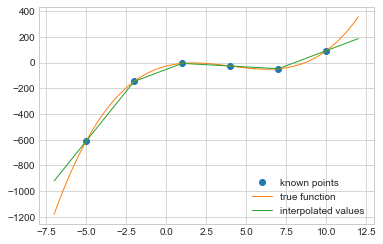

In [35]:
# a. construct interpolation function
interp_func = interpolate.RegularGridInterpolator([G],F,
                                                  bounds_error=False,
                                                  fill_value=None)

# bounds_error=False and fill_value=None allow for extrapolation

# b. interpolate
grid = np.linspace(-7,12,500)
interp_values = interp_func(grid)

# c. evaluate true values
true_values = f(grid)

# d. plot true and interpolated values
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(G,F,'o',label='known points')
ax.plot(grid,true_values,'-',lw=1,label='true function')
ax.plot(grid,interp_values,'-',lw=1,label='interpolated values')
ax.legend(loc='lower right');

**Note:**

1. Linear interpolation works best when the function does not curve too much.
2. Extrapolation is much worse than interpolation.

**Multiple dimensions:** Same principle, ``interpolate.RegularGridInterpolator([G1,G2,G3],F)``.

# Dynamic optimization problems

The following subject is hard. But also extremely useful. *If you master this, you can solve (almost) all economic models you meet on your way in life*.

## Problem formulation

Consider a **household** living in two periods.

In the **second period** it gets utility from **consuming** and **leaving a bequest** (warm glow),

\begin{eqnarray*}
v_{2}(m_{2})&=&\max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho}\\&\text{s.t.}&\\c_{2}&\in&[0,m_{2}]
\end{eqnarray*}

where 

* $m_2$ is cash-on-hand 
* $c_2$ is consumption
* $\rho > 1$ is the risk aversion coefficient
* $\nu > 0 $ is the strength of the bequest motive
* $\kappa > 0$ is the degree of luxuriousness in the bequest motive  
* the constraint ensures the household *cannot* die in debt

The **value function** $v(m_2)$ measures the household's value of having $m_2$ at the beginning of period 2.

In [36]:
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def bequest(m,c,nu,kappa,rho):
    return nu*(m-c+kappa)**(1-rho)/(1-rho)

def v2(c2,m2,rho,nu,kappa):
    return utility(c2,rho) + bequest(m2,c2,nu,kappa,rho)

In the **first period**, the household gets utility from consuming and takes into account that it will also live in the next-period, where it receives a stochastic income,

$$
\begin{eqnarray*}
v_{1}(m_{1})&=&\max_{c_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right]\\&\text{s.t.}&\\
m_2&=&(1+r)(m_{1}-c_{1})+y_{2} \\
y_{2}&=&\begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
c_{1}&\in&[0,m_{1}]\\
\end{eqnarray*}
$$

where

* $m_1$ is cash-on-hand in period 1
* $c_1$ is consumption in period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y_2$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the return on savings
* the last constraint ensures the household *cannot* borrow

In [37]:
def v1(c1,m1,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-c1) + 1-Delta
    v2_low = v2_interp([m2_low])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*(m1-c1) + 1+Delta
    v2_high = v2_interp([m2_high])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,rho) + beta*v2

## Solve household problem

Choose **parameters**:

In [38]:
rho = 8
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.94
Delta = 0.5

**Solve second period:**

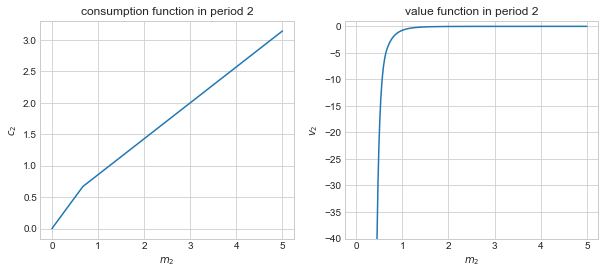

In [39]:
def solve_period_2(rho,nu,kappa,Delta):

    # a. grids
    m2_vec = np.linspace(1e-8,5,500)
    v2_vec = np.empty(500)
    c2_vec = np.empty(500)

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):

        # i. objective
        obj = lambda c2: -v2(c2,m2,rho,nu,kappa)

        # ii. initial value (consume half)
        x0 = m2/2

        # iii. optimizer
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x
        
    return m2_vec,v2_vec,c2_vec

# solve
m2_vec,v2_vec,c2_vec = solve_period_2(rho,nu,kappa,Delta)

# illustration
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m2_vec,c2_vec)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$c_2$')
ax.set_title('consumption function in period 2')

ax = fig.add_subplot(1,2,2)
ax.plot(m2_vec,v2_vec)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$v_2$')
ax.set_title('value function in period 2')
ax.set_ylim([-40,1]);

**Question:** Why is there a kink in the consumption function?

**Construct interpolator:**

In [40]:
v2_interp = interpolate.RegularGridInterpolator([m2_vec], v2_vec,
                                                bounds_error=False,fill_value=None)

**Solve first period:**

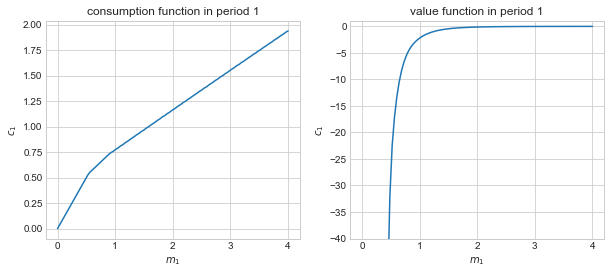

In [41]:
def solve_period_1(rho,beta,r,Delta,v2_interp):

    # a. grids
    m1_vec = np.linspace(1e-8,4,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda c1: -v1(c1,m1,rho,beta,r,Delta,v2_interp)
        
        # ii. initial guess (consume half)
        x0 = m1*1/2
        
        # iii. optimize
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m1])
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x
     
    return m1_vec,v1_vec,c1_vec

# solve
m1_vec,v1_vec,c1_vec = solve_period_1(rho,beta,r,Delta,v2_interp)

# illustrat
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m1_vec,c1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')

ax = fig.add_subplot(1,2,2)
ax.plot(m1_vec,v1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('value function in period 1')
ax.set_ylim([-40,1]);

**Summary:** We can summarize what we have done in a single function doing:

1. Solve period 2 (i.e. find $v_2(m_2)$ og $c_2(m_2)$)
2. Construct interpolator of $v_2(m_2)$
3. Solve period 1 (i.e. find $v_1(m_1)$ og $c_1(m_1)$)

In [42]:
def solve(rho,beta,r,Delta,nu,kappa):
    
    # a. solve period 2
    m2_vec,v2_vec,c2_vec = solve_period_2(rho,nu,kappa,Delta)
    
    # b. construct interpolator
    v2_interp = interpolate.RegularGridInterpolator([m2_vec], v2_vec,
        bounds_error=False,fill_value=None)
    
    # b. solve period 1
    m1_vec,v1_vec,c1_vec = solve_period_1(rho,beta,r,Delta,v2_interp)
    
    return m1_vec,c1_vec

**Plot consumption function for various level of income risk**, i.e varios $\Delta$

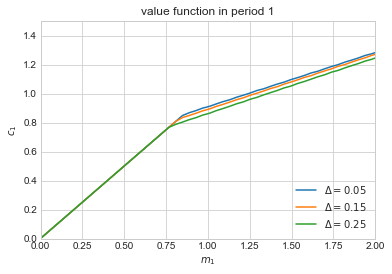

In [43]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for Delta in [0.05,0.15,0.25]:
    m1_vec,c1_vec = solve(rho,beta,r,Delta,nu,kappa)
    
    ax.plot(m1_vec,c1_vec,label=f'$\Delta = {Delta}$')

ax.legend(loc='lower right')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('value function in period 1')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5]);

**Main takeaway:** The household lower its consumption when risk increases (such as in a recession). This is called **precautionary saving**.

# Summary

**This lecture:**

1. Solving multidimensional optimization problems with and without gradients (and hessians)
2. Using multistart to alleviate problems with local minima (due to non-convexities)
3. Linear interpolation between known points
4. Solving dynamic optimization problems backwards period-by-period 

**Dynamic optimization:** Extremely useful technique. Can handle multiple periods, multiple states and choices, more shocks etc. You can solve general equilibrium models where the households solve such problems.

**Next lecture:** The Need for Speed.